In [ ]:
import torch # We no longer import as tch
import torch.nn as nn
import numpy as np
import torchvision # Contains data sets and functions for image processing
import torchvision.transforms as transforms # Contains MNIST, other image datasets, and image processing functions
import matplotlib.pyplot as plt
from time import time as tm
import torch.nn.functional as F 
from copy import deepcopy
import seaborn as sns

# Import TorchSeq2PC 
!git clone https://github.com/RobertRosenbaum/Torch2PC.git
from Torch2PC import TorchSeq2PC as T2PC

SaveFigures=False

if SaveFigures:
  from google.colab import drive
  drive.mount("/content/gdrive/")
  

torch.manual_seed(0)

# # This patches an error that sometimes arises in
# # downloading MNIST
# from six.moves import urllib
# opener = urllib.request.build_opener()
# opener.addheaders = [('User-agent', 'Mozilla/5.0')]
# urllib.request.install_opener(opener)

# # This can also help errors that arise sometimes
# # when downloading MNIST
!wget -nc www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz


# Load training and testing data from MNIST dataset
# These lines return data structures that contain
# the training and testing data 
from torchvision.datasets import MNIST

train_dataset = MNIST('./', 
      train=True, 
      transform=transforms.ToTensor(),  
      download=True)

test_dataset = MNIST('./', 
      train=False, 
      transform=transforms.ToTensor(),  
      download=True)


#train_dataset.data=train_dataset.data/255.0
#test_dataset.data=test_dataset.data/255.0

# Print the size of the two data sets
m = len(train_dataset)
mtest = len(test_dataset)
print("Number of data points in training set = ",m)
print("Number of data points in test set=",mtest)

# train_dataset.data contains all the MNIST images (X) 
# train_dataset.targets contains all the labels (Y)
print("Size of training inputs (X)=",train_dataset.data.size())
print("Size of training labels (Y)=",train_dataset.targets.size())


Cloning into 'Torch2PC'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 47 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), done.
Running TorchSeq2PC.py
Mounted at /content/gdrive/
--2021-06-17 14:16:26--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-06-17 14:16:26--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [     <=>            ]  33.20M  34.5MB/s    in 1.0s    

2021-06-17 14:16:27 (34.5 M

In [ ]:
batch_size = 300      # Batch size to use with training data
test_batch_size = 300 # Batch size to use for test data

# Data loader. These make it easy to iterate through batches of data.
# Shuffle=True means that the data will be randomly shuffled on every epoch
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=test_batch_size,
                                          shuffle=True)


steps_per_epoch = len(train_loader) # = mini batch size = m'
print("steps per epoch (mini batch size)=",steps_per_epoch)


steps per epoch (mini batch size)= 200


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = ',device)

model=nn.Sequential(
    
    nn.Sequential(nn.Conv2d(1,10,3),
    nn.ReLU(),
    nn.MaxPool2d(2)
    ),

    nn.Sequential(
    nn.Conv2d(10,5,3),
    nn.ReLU(),
    nn.Flatten()
    ),

 nn.Sequential(    
    nn.Linear(5*11*11,50),
    #nn.BatchNorm1d(50),
    nn.ReLU()
    ),

 nn.Sequential(    
    nn.Linear(50,30),
    nn.ReLU()
    ),


nn.Sequential(
   nn.Linear(30,10)
 )

).to(device)

LossFun = nn.CrossEntropyLoss()

# Compute one output and one loss to make sure
# things are working
with torch.no_grad():
  TrainingIterator=iter(train_loader)
  X,Y=next(TrainingIterator)  
  X=X.to(device)
  Y=Y.to(device)
  Yhat=model(X).to(device)
  print('output shape = ',Yhat.shape)
  print('loss on initial model = ',LossFun(Yhat,Y).item())


NumParams=sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters in model =',NumParams)

LearningRate=.002
num_epochs=2
ComputeTrainingMetrics=True
WhichOptimizer=torch.optim.Adam
PrintEvery=50
total_num_steps  = num_epochs*steps_per_epoch

device =  cuda
output shape =  torch.Size([300, 10])
loss on initial model =  2.315197229385376
Number of trainable parameters in model = 32695


k = 0 i = 0 L = 2.3021225929260254
k = 0 i = 50 L = 0.6909289360046387
k = 0 i = 100 L = 0.34052371978759766
k = 0 i = 150 L = 0.32914742827415466
k = 1 i = 0 L = 0.24988077580928802
k = 1 i = 50 L = 0.19794440269470215
k = 1 i = 100 L = 0.19146189093589783
k = 1 i = 150 L = 0.13351288437843323
Training time =  39.62808585166931 sec


Text(0, 0.5, 'rel err of dtheta')

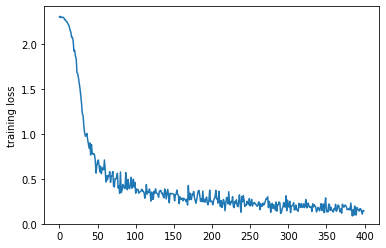

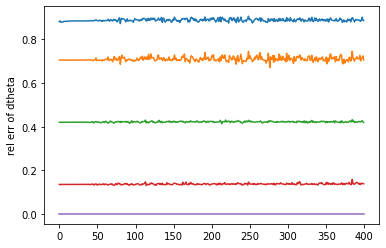

In [ ]:
torch.manual_seed(0)

modelPC=deepcopy(model)


optimizerPC = WhichOptimizer(modelPC.parameters(), lr=LearningRate)


jj=0
LossesToPlotPC=np.zeros(total_num_steps)
TestLossesToPlotPC=np.zeros(total_num_steps)
AccuraciesToPlotPC=np.zeros(total_num_steps)
TestAccuraciesToPlotPC=np.zeros(total_num_steps)

GradsRelDiff0=np.zeros([total_num_steps,len(model)])
GradsCosSim0=np.zeros([total_num_steps,len(model)])
GradsAngle0=np.zeros([total_num_steps,len(model)])

def RelDiff(x,y):
  return np.linalg.norm(x-y)/np.linalg.norm(y)

def corr2(x,y):
  c=np.corrcoef(x,y)
  return c[0,1]

CosSim = nn.CosineSimilarity(dim=0, eps=1e-8)

eta=.1
n=20

j=0     # Counter to keep track of iterations
t1=tm() # Start the timer

for k in range(num_epochs):

  # Re-initializes the training iterator (shuffles data for one epoch)
  TrainingIterator=iter(train_loader)
  
  for i in range(steps_per_epoch): # For each batch

    # Get one batch of training data, reshape it
    # and send it to the current device        
    X,Y=next(TrainingIterator)  
    X=X.to(device)
    Y=Y.to(device)

    
    _,Loss,_,_,_=T2PC.PCInfer(modelPC,LossFun,X,Y,"FixedPred",eta,n)
    
    if ComputeTrainingMetrics:
      modelBP=deepcopy(modelPC)   # Copy the model
      YhatBP = modelBP(X)         # Forward pass
      LossBP = LossFun(YhatBP, Y)        
      LossBP.backward()       # Compute gradients
      for layer in range(len(model)):
        gradsPC=modelPC[layer][0].weight.grad.cpu().detach().numpy()      
        gradsBP=modelBP[layer][0].weight.grad.cpu().detach().numpy()
        GradsRelDiff0[jj,layer]=RelDiff(gradsPC,gradsBP)
        GradsCosSim0[jj,layer]=CosSim(torch.tensor(gradsPC.flatten()),torch.tensor(gradsBP.flatten())).item()
        GradsAngle0[jj,layer]=torch.acos(torch.tensor(GradsCosSim0[jj,layer])).item()
      modelBP.zero_grad()


    # Update parameters    
    optimizerPC.step() 

    # Zero-out gradients     
    modelPC.zero_grad()
    optimizerPC.zero_grad()

    # Print loss, store loss, compute test loss
    with torch.no_grad():
      if(i%PrintEvery==0):
        print('k =',k,'i =',i,'L =',Loss.item())
      LossesToPlotPC[jj]=Loss.item() 
      if ComputeTrainingMetrics:    
        Yhat=modelPC(X)
        AccuraciesToPlotPC[jj]=(torch.sum(Y==torch.argmax(Yhat,axis=1))/test_batch_size).item()    
        modelPC.eval()
        TestingIterator=iter(test_loader)     
        Xtest,Ytest=next(TestingIterator)
        Xtest=Xtest.to(device)
        Ytest=Ytest.to(device)        
        YhatTest=modelPC(Xtest)
        TestLossesToPlotPC[jj]=LossFun(YhatTest,Ytest).item()                   
        TestAccuraciesToPlotPC[jj]=(torch.sum(Ytest==torch.argmax(YhatTest,axis=1))/test_batch_size).item()
        modelPC.train()
      jj+=1

tTrain=tm()-t1
print('Training time = ',tTrain,'sec')


plt.figure()
plt.plot(LossesToPlotPC)
plt.ylim(bottom=0)  
plt.ylabel('training loss')

plt.figure()
plt.plot(GradsRelDiff0)
plt.ylabel('rel err of dtheta')

     

k = 0 i = 0 L = 2.3021225929260254
k = 0 i = 50 L = 0.6909552216529846
k = 0 i = 100 L = 0.3098435401916504
k = 0 i = 150 L = 0.31458526849746704
k = 1 i = 0 L = 0.23264074325561523
k = 1 i = 50 L = 0.1618623286485672
k = 1 i = 100 L = 0.15504741668701172
k = 1 i = 150 L = 0.1076405867934227
Training time =  15.68958306312561 sec


Text(0, 0.5, 'training loss')

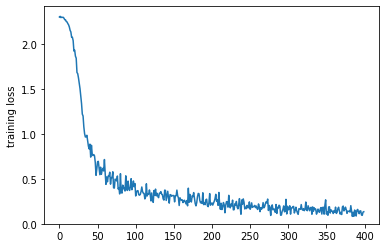

In [ ]:
torch.manual_seed(0)

modelBP=deepcopy(model)

optimizerBP = WhichOptimizer(modelBP.parameters(), lr=LearningRate)

total_num_steps  = num_epochs*steps_per_epoch


jj=0
LossesToPlotBP=np.zeros(total_num_steps)
TestLossesToPlotBP=np.zeros(total_num_steps)
AccuraciesToPlotBP=np.zeros(total_num_steps)
TestAccuraciesToPlotBP=np.zeros(total_num_steps)


DepthPlusOne=len(modelBP)+1 # Number of layers, counting the input as layer 0  

j=0     # Counter to keep track of iterations
t1=tm() # Start the timer
for k in range(num_epochs):

  # Re-initializes the training iterator (shuffles data for one epoch)
  TrainingIterator=iter(train_loader)

  for i in range(steps_per_epoch): # For each batch

    # Get one batch of training data, reshape it
    # and send it to the current device        
    X,Y=next(TrainingIterator)  
    X=X.to(device)
    Y=Y.to(device)


    Yhat = modelBP(X)     # Forward pass
    Loss = LossFun(Yhat, Y)        
    Loss.backward()       # Compute gradients
    optimizerBP.step()      # Update parameters


    # Zero-out gradients 
    modelBP.zero_grad() 
    optimizerBP.zero_grad() 

    with torch.no_grad():
      if(i%PrintEvery==0):
        print('k =',k,'i =',i,'L =',Loss.item())
      LossesToPlotBP[jj]=Loss.item()      
      if ComputeTrainingMetrics:   
        AccuraciesToPlotBP[jj]=(torch.sum(Y==torch.argmax(Yhat,axis=1))/test_batch_size).item()
        modelBP.eval() 
        TestingIterator=iter(test_loader)
        Xtest,Ytest=next(TestingIterator)
        Xtest=Xtest.to(device)
        Ytest=Ytest.to(device)
        YhatTest=modelBP(Xtest)        
        TestLossesToPlotBP[jj]=LossFun(YhatTest,Ytest).item()             
        TestAccuraciesToPlotBP[jj]=(torch.sum(Ytest==torch.argmax(YhatTest,axis=1))/test_batch_size).item()
        modelBP.train()
      jj+=1

tTrainBP=tm()-t1
print('Training time = ',tTrainBP,'sec')


plt.figure()
plt.plot(LossesToPlotBP)
plt.ylim(bottom=0)
plt.ylabel('training loss')


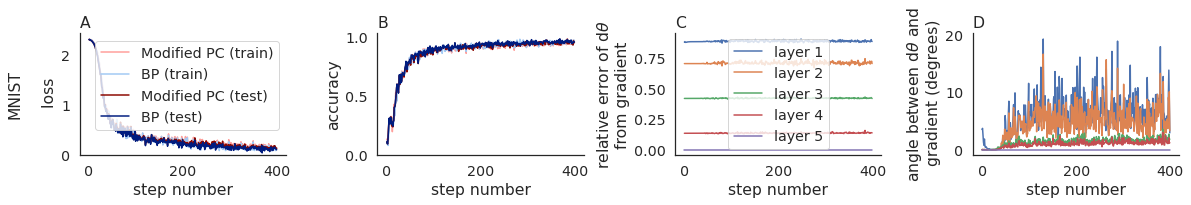

In [ ]:

sns.set(context='notebook',style='white',font_scale=1.3)

fig, axes = plt.subplots(figsize=(17, 3))


plt.subplot(1,4,1)
plt.plot(LossesToPlotPC,color=sns.color_palette('pastel')[3],label='Modified PC (train)')
plt.plot(LossesToPlotBP,color=sns.color_palette('pastel')[0],label='BP (train)')
plt.plot(TestLossesToPlotPC,color=sns.color_palette('dark')[3],label='Modified PC (test)')
plt.plot(TestLossesToPlotBP,color=sns.color_palette('dark')[0],label='BP (test)')
plt.xlabel('step number')
plt.ylabel('MNIST\n\n loss')
sns.despine()
plt.legend()
plt.ylim(bottom=0)
plt.title('A',loc='left')



plt.subplot(1,4,2)
plt.plot(AccuraciesToPlotPC,color=sns.color_palette('pastel')[3],label='Modified PC (train)')
plt.plot(AccuraciesToPlotBP,color=sns.color_palette('pastel')[0],label='BP (train)')
plt.plot(TestAccuraciesToPlotPC,color=sns.color_palette('dark')[3],label='Modified PC (test)')
plt.plot(TestAccuraciesToPlotBP,color=sns.color_palette('dark')[0],label='BP (test)')
plt.xlabel('step number')
plt.ylabel('accuracy')
sns.despine()
#plt.legend()
plt.ylim(bottom=0)
plt.title('B',loc='left')


plt.subplot(1,4,3)
for layer in range(len(model)):
  plt.plot(GradsRelDiff0[:,layer],label='layer '+str(layer+1))
#plt.plot(GradsRelDiff)
plt.xlabel('step number')
plt.ylabel(r'relative error of d$\theta$'+'\nfrom gradient')
plt.legend(loc='center')
sns.despine()
plt.title('C',loc='left')
 

plt.subplot(1,4,4)
plt.plot((180/3.14159)*GradsAngle0)
plt.xlabel('step number')
plt.ylabel(r'angle between d$\theta$ and'+'\n gradient (degrees)')
sns.despine()
plt.title('D',loc='left')

plt.tight_layout()

if SaveFigures:
  plt.savefig('/content/gdrive/MyDrive/PredictiveCodingANN/Figures/FixedPredPCMNIST.pdf')


In [ ]:

torch.manual_seed(0)

UseTrainedModel=True

n=200

etas=[0.1,0.2,0.5,1]


def RelDiff(x,y):
  return np.linalg.norm(x-y)/np.linalg.norm(y)

def corr2(x,y):
  c=np.corrcoef(x,y)
  return c[0,1]


GradsRelDiff=np.zeros([len(etas),len(model),n])
ErrsRelDiff=np.zeros([len(etas),len(model),n])
GradsAngle=np.zeros([len(etas),len(model),n])
GradsCosSim=np.zeros([len(etas),len(model),n])


for jj in range(len(etas)):


  eta=etas[jj]

  if UseTrainedModel:
    modelPC=deepcopy(modelBP)
    modelBP0=deepcopy(modelBP)
  else:
    modelPC=deepcopy(model)
    modelBP0=deepcopy(model)




  TrainingIterator=iter(train_loader)

  # Get one batch of training data, reshape it
  # and send it to the current device        
  X,Y=next(TrainingIterator)  
  X=X.to(device)
  Y=Y.to(device)


  # Compute BP gradients
  torch.manual_seed(0)
  vhatBP,LossBP,dLdyBP,vBP,epsilonBP=T2PC.PCInfer(modelBP0,LossFun,X,Y,"Exact")


  # Number of layers, counting the input as layer 0 
  DepthPlusOne=len(modelPC)+1 

  modelPC.zero_grad()

  # Initialize epsilons
  epsilon=[None]*DepthPlusOne
  epsilon[-1]=dLdyBP

  # Initialize v to a copy of vhat with no gradients needed
  # (can this be moved up to the loop above?)

  # Forward pass
  torch.manual_seed(0)
  vhat=[None]*DepthPlusOne
  vhat[0]=X
  for layer in range(1,DepthPlusOne):
    f=modelPC[layer-1]
    vhat[layer]=f(vhat[layer-1])

  

  v=[None]*DepthPlusOne
  for layer in range(DepthPlusOne):
    v[layer]=vhat[layer].clone().detach()

  # Iterative updates of v and epsilon using stored values of vhat   
  torch.manual_seed(0) 
  for i in range(n):
    modelPC.zero_grad()
    for layer in reversed(range(DepthPlusOne-1)):
      epsilon[layer]=vhat[layer]-v[layer]
      _,epsdfdv=torch.autograd.functional.vjp(modelPC[layer],vhat[layer],epsilon[layer+1])               
      dv=epsilon[layer]-epsdfdv
      v[layer]=v[layer]+eta*dv

    # Compute new parameter values 
    for layer in range(0,DepthPlusOne-1):
      for p in modelPC[layer].parameters():
        dtheta=torch.autograd.grad(vhat[layer+1],p,grad_outputs=epsilon[layer+1],allow_unused=True,retain_graph=True)[0]
        p.grad = dtheta

    for layer in range(0,DepthPlusOne-1):
        gradsPC=modelPC[layer][0].weight.grad.cpu().detach().numpy()
        gradsBP=modelBP0[layer][0].weight.grad.cpu().detach().numpy()
        GradsRelDiff[jj,layer,i]=RelDiff(gradsPC,gradsBP)#epsilonBP[layer].cpu().detach().numpy(),epsilon[layer].cpu().detach().numpy())
        ErrsRelDiff[jj,layer,i]=RelDiff(epsilon[layer+1].cpu().detach().numpy(),epsilonBP[layer+1].cpu().detach().numpy())
        GradsCosSim[jj,layer,i]=CosSim(torch.tensor(gradsPC.flatten()),torch.tensor(gradsBP.flatten())).item()
        GradsAngle[jj,layer,i]=torch.acos(torch.tensor(GradsCosSim[jj,layer,i])).item()





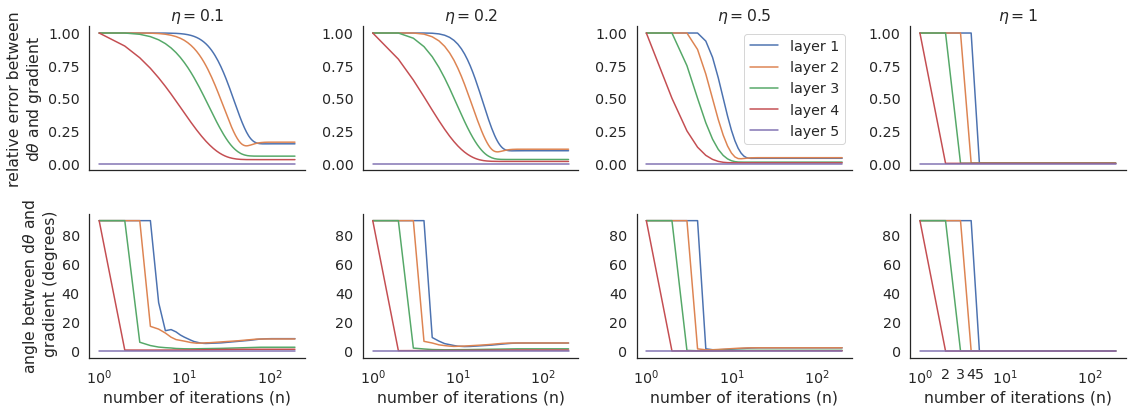

In [ ]:

sns.set(context='notebook',style='white',font_scale=1.3)

fig, axes = plt.subplots(figsize=(16, 6))

for kk in range(len(etas)):
  plt.subplot(2,4,kk+1)
  for layer in range(0,DepthPlusOne-1):
    plt.plot(np.arange(1,n+1),GradsRelDiff[kk,layer,:].T,label='layer '+str(layer+1))
  plt.title('$\eta=$'+str(etas[kk]))
  plt.xscale('log')
  sns.despine()
  if kk==0:
    plt.ylabel('relative error between\n'+r'd$\theta$ and gradient')
  if kk==2:
    plt.legend()    
  plt.xticks([])


for kk in range(len(etas)):
  plt.subplot(2,4,4+kk+1)
  for layer in range(0,DepthPlusOne-1):
    plt.plot(np.arange(1,n+1),(180/3.14159)*GradsAngle[kk,layer,:].T,label='layer '+str(layer+1))
  plt.xscale('log')
  plt.xlabel('number of iterations (n)')
  sns.despine()
  if kk==0:
    plt.ylabel(r'angle between d$\theta$ and'+'\n gradient (degrees)')
  if kk==3:
    plt.xticks([1,2,3,4,5,10,100],['$10^0$','2','3','4','5','$10^1$','$10^2$'])
    

plt.tight_layout()


if SaveFigures:  
  plt.savefig('/content/gdrive/MyDrive/PredictiveCodingANN/Figures/FixedPredPCMNISTErrsVsIts.pdf')
